# Test Reference Imputation Methods from Implemented by Different Python and R Packages

In [28]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
from fastcore.test import test_eq, test

from pyproteonet.simulation import molecule_set_from_degree_distribution, simulate_protein_peptide_dataset, simulate_mcars, simulate_mnars_thresholding
from pyproteonet.aggregation import maxlfq
from pyproteonet.processing import logarithmize

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Simulating a Dataset

In [2]:
# We define some degree distributions roughly assembling those of a real world dataset
protein_deg_distribution = [0, 0.1445, 0.1221, 0.1151, 0.0933, 0.0692, 0.0655, 0.0508, 0.0472, 0.0362, 0.0311, 0.0277, 0.0209, 0.0199, 0.0163, 0.0143,
                            0.012, 0.0105, 0.0093, 0.0087, 0.0081, 0.0063, 0.0063, 0.0055, 0.0054, 0.0043, 0.0043, 0.0042, 0.0039, 0.0037, 0.0034,
                            0.0031, 0.0022, 0.0021, 0.0019, 0.0019, 0.0019, 0.0015, 0.0012, 0.001, 0.001]
peptide_deg_distribution = [0, 0.9591, 0.0341, 0.0046, 0.0014]

First, we create a set of proteins with related peptides.
Next, we simulate abundance values for those peptides

In [3]:
# We create a simulated dataset with 100 proteins and 10 samples
num_proteins = 100
num_samples = 10

# We use a simple heuristic to determine the number of peptides for the given number of proteins while still closely matching the degree distributions
protein_degs = np.round(num_proteins * np.array(protein_deg_distribution))
prot_edges = np.sum(np.arange(len(protein_deg_distribution)) * protein_degs)
num_peptides = 1
pep_edges = 0
while pep_edges < prot_edges:
    num_peptides += 1
    peptide_degs = np.round(num_peptides * np.array(peptide_deg_distribution))
    pep_edges = np.sum(np.arange(len(peptide_deg_distribution)) * peptide_degs)
if pep_edges > prot_edges:
    diff = pep_edges - prot_edges
    for i in range(len(peptide_degs)-1, -1, -1):
        if peptide_degs[i] > 0 and i <= diff:
            peptide_degs[i] -= 1
            diff -= i
        if diff == 0:
            break

# Create a protein peptide molecule set for the given number of proteins/peptides and degree distribution
ms = molecule_set_from_degree_distribution(molecule1_name='protein', molecule2_name='peptide', mapping_name='peptide-protein',
                                           molecule1_degree_distribution=protein_degs, molecule2_degree_distribution=peptide_degs)
# Lets simulate some abundance values for the given molecule set
ds = simulate_protein_peptide_dataset(molecule_set=ms, mapping='peptide-protein', samples=num_samples,
                                      log_abundance_mu=15.9, log_abundance_sigma=1.8,
                                      log_protein_error_sigma=0.3, peptide_noise_sigma= 115005.3,
                                      flyability_alpha=0.7, flyability_beta=2.1, simulate_flyability=True)

Finally, we incorporate some missing values (MNARs and MCARs)

In [4]:
simulate_mnars_thresholding(dataset=ds, thresh_mu=115005.3 / 2, thresh_sigma=115005.3 / 4, molecule='peptide', column='abundance',
                            result_column='abundance_missing', mask_column='is_mnar', inplace=True)
simulate_mcars(dataset=ds, amount=0.3, molecule='peptide', column='abundance', result_column='abundance_missing', mask_column='is_mcar', inplace=True)

In the end all abundance/aggregated values are logarithmized as it is commonly done in proteomics because logarithmized values are more normally distributed.

In [5]:
ds = logarithmize(data=ds, columns=['abundance', 'abundance_gt', 'abundance_missing'])

## MaxLFQ aggregation

In [6]:
ds.values['protein']['aggregated'] = maxlfq(dataset=ds, molecule='protein', mapping='peptide-protein', partner_column='abundance_missing',
                                            min_ratios=2, median_fallback=False, is_log=True)

/hpi/fs00/home/tobias.pietz/MasterThesis/pyproteonet/pyproteonet/aggregation/maxlfq.py:186: NumbaTypeSafetyWarning: unsafe cast from uint64 to int64. Precision may be lost.
  grouping = mask_group(groupings[group_idx])


Now the 'aggregated' value column holds the aggregated values and the 'abundance_gt' value column which was written during the simulation
holds the ground truth values

In [7]:
ds.values['protein'].df

abundance_gt  aggregated
sample  id                          
sample0 0      13.948428         NaN
        1      16.952193         NaN
        2      17.986372         NaN
        3      13.651170         NaN
        4      18.103025         NaN
...                  ...         ...
sample9 92     17.576737   16.061718
        93     14.375261   12.758782
        94     17.595139   15.599724
        95     16.932829   15.506549
        96     19.722344   18.222623

[970 rows x 2 columns]

## Imputation

### Imputation Methods Available Through High Level API

  0%|          | 0/13 [00:00<?, ?it/s]

Imputing with methods minprob, storing results in value column minprob
[1] 0.2732107
Imputing with methods mindet, storing results in value column mindet
Imputing with methods mean, storing results in value column mean
Imputing with methods bpca, storing results in value column bpca
Imputing with methods bpca_t, storing results in value column bpca_t
Imputing with methods missforest, storing results in value column missforest
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Imputing with methods missforest_t, storing results in value column missforest_t
Imputing with methods knn, storing results in value column knn
Imputing with methods isvd, storing results in value column isvd
[IterativeSVD] Iter 1: observed MAE=0.893002
[IterativeSVD] Iter 2: observed MAE=0.347177
[IterativeSVD] Iter 3: observed MAE=0.253026
[IterativeSVD] Iter 4: observed MAE=0.225474
[IterativeSVD] Iter 5: observed MAE=0.214634
[IterativeSVD] Iter 6: observed 

epoch,train_loss,valid_loss,time
0,731.957642,56.729218,00:00
1,725.399841,56.660103,00:00
2,720.705200,56.486706,00:00
3,714.425781,56.124535,00:00
4,705.094849,55.676922,00:00
5,690.942383,55.072472,00:00
6,671.589111,54.282215,00:00
7,648.914612,53.347149,00:00
8,622.325134,52.344154,00:00
9,592.969482,51.066265,00:00


Imputing with methods vae, storing results in value column vae


epoch,train_loss,valid_loss,time
0,103.160851,13.271466,00:00
1,104.159790,13.373545,00:00
2,104.544380,13.346387,00:00
3,104.307228,12.911522,00:00
4,103.944855,12.849333,00:00
5,103.749016,13.400736,00:00
6,103.509804,13.107941,00:00
7,103.194153,12.600214,00:00
8,102.667015,13.056972,00:00
9,102.188309,12.378316,00:00


Imputing with methods cf, storing results in value column cf


suggested_lr.valley = 0.00048


epoch,train_loss,valid_loss,time
0,2.446414,None,00:00
1,2.446336,None,00:00
2,2.446151,None,00:00
3,2.445770,None,00:00
4,2.445160,None,00:00
5,2.444318,None,00:00
6,2.443277,None,00:00
7,2.442083,None,00:00
8,2.440774,None,00:00
9,2.439385,None,00:00


(707, 1)


(800,)


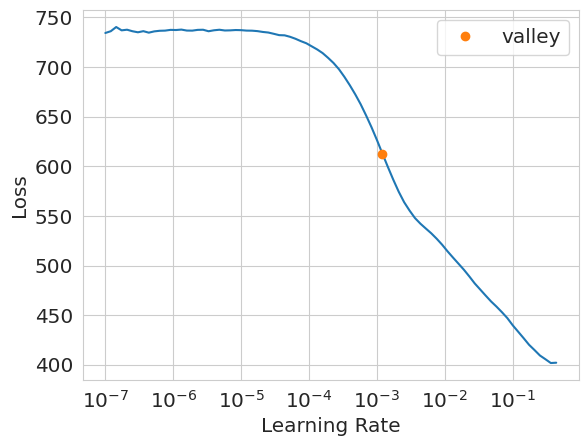

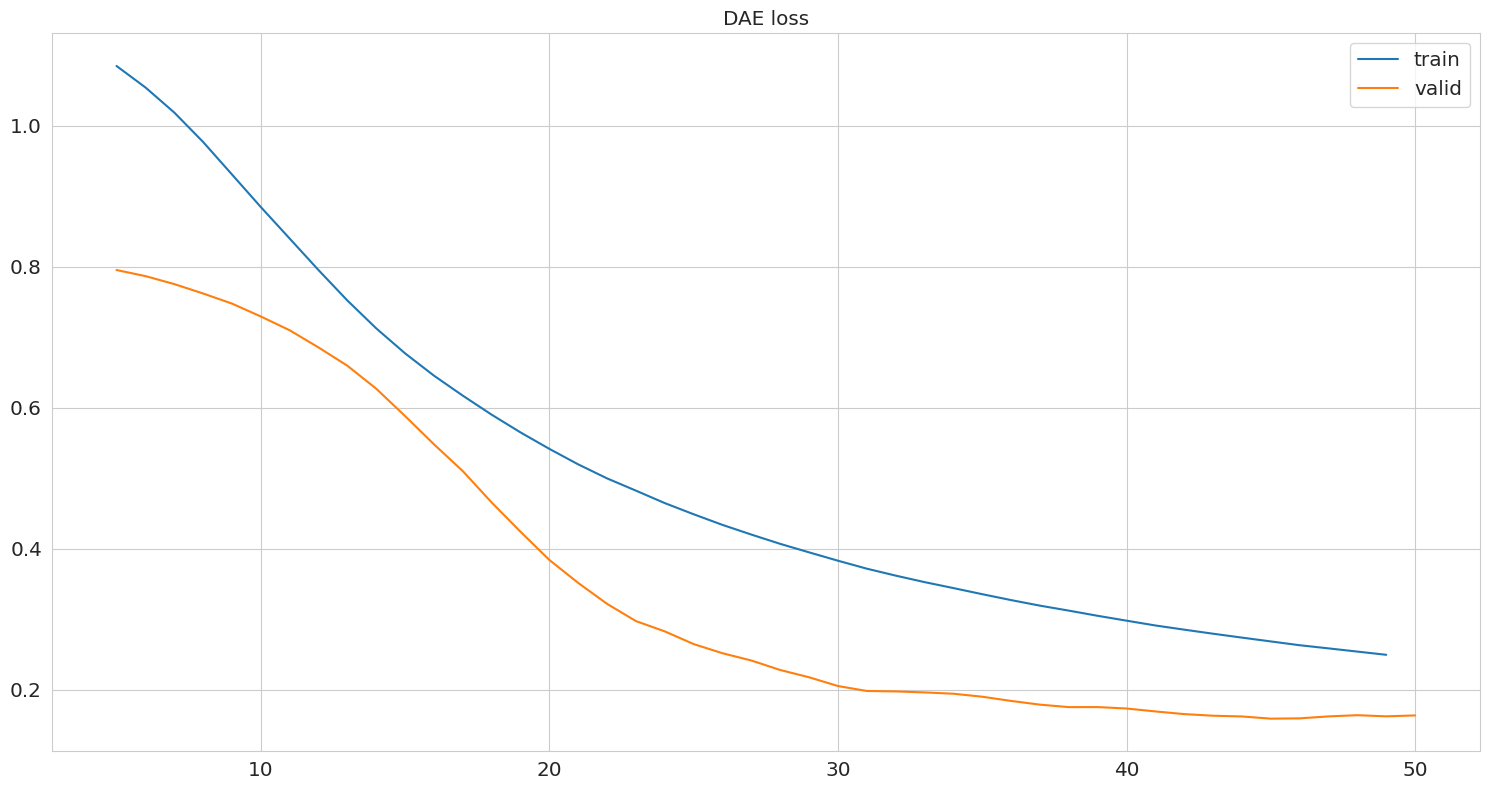

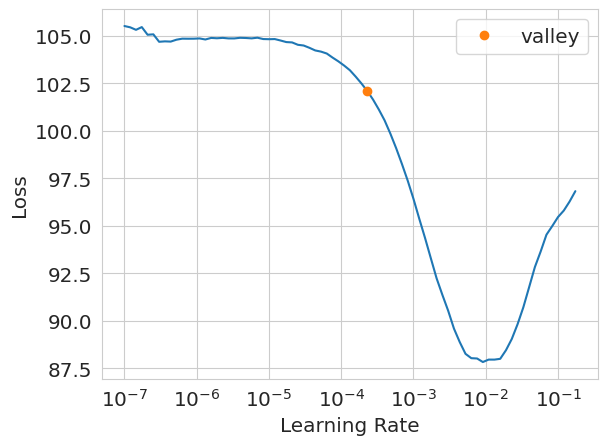

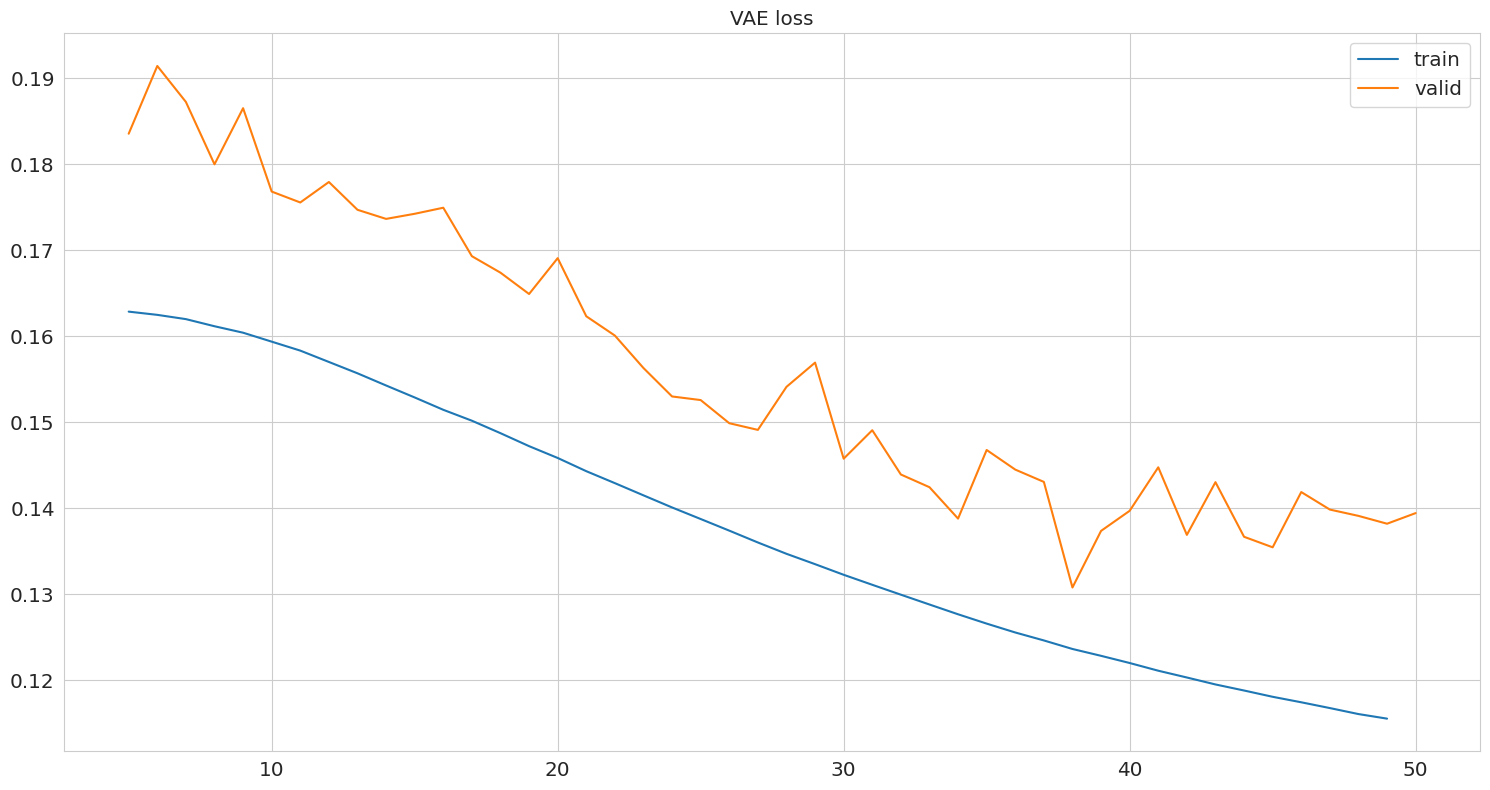

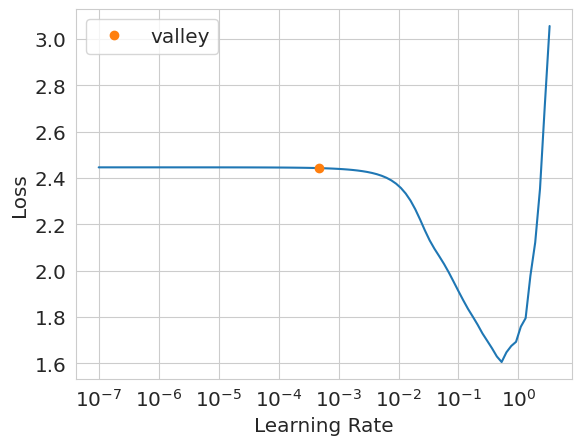

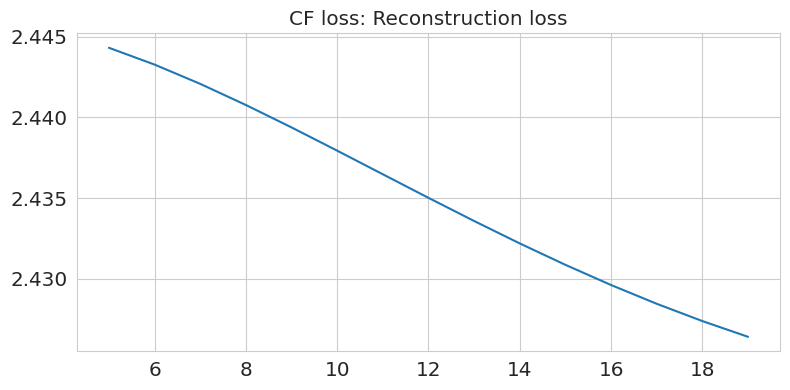

In [13]:
from pyproteonet.imputation import impute_molecule

# run all imputation methods
impute_molecule(dataset=ds, molecule='protein', column='aggregated', methods=None)

In [15]:
# verify that there are missing values in the orignal data
test_eq(ds.values['protein']['aggregated'].isna().sum()>0, True)

In [27]:
from pyproteonet.imputation.high_level_api import ALL_IMPUTATION_METHODS
# Verify that each imputation method ran and imputed values
num_missing = ds.values['protein']['aggregated'].isna().sum()
for m in ALL_IMPUTATION_METHODS:
    test_eq(ds.values['protein'][m].isna().sum() < num_missing,True)

### Additional Imputation methods wrapped from MsCoreUtils

In [54]:
from pyproteonet.imputation.r.ms_core_utils import SUPPORTED_IMPUTATION_METHODS, impute_ms_core_utils

for m in SUPPORTED_IMPUTATION_METHODS:
    print(m)
    impute_ms_core_utils(dataset=ds, molecule='protein', column='aggregated', method=m, result_column=m)
    test_eq(ds.values['protein'][m].isna().sum() < num_missing,True)

MLE
Iterations of EM: 
1...2...3...4...5...6...7...8...9...10...11...12...13...14...
QRILC
MinDet
MinProb
[1] 0.2732107
min
zero


###